# Build and Train SiameseNet with Triplet Loss

In [1]:
from utils import get_faces_df
import numpy as np
from keras.utils import Sequence
from keras.layers import Input, Dense, LeakyReLU, Concatenate, Lambda, BatchNormalization, GlobalAveragePooling2D
from keras.applications.xception import Xception, preprocess_input
from keras import backend as K
from keras.models import Model
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline

BATCH_SIZE = 2
FACE_DEFAULT_SHAPE = (218, 178)

# Path to celeb dataset
PATH = './'

df_train, df_valid, df_test, _ = get_faces_df(PATH)

Using TensorFlow backend.


Train images: 162770
Validation images: 19867
Test images: 19962


### Visualize few images of the same person

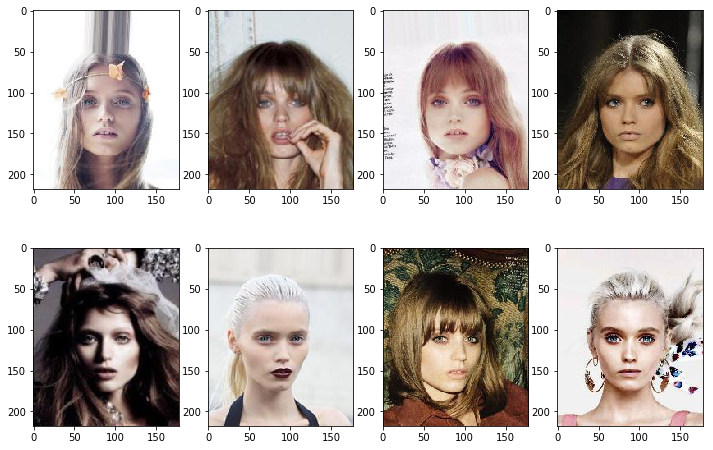

In [2]:
files = df_train.iloc[df_train['label'].values == 27]['image'].values
rnd_files = np.random.choice(files, 8, replace=False)

plt.figure(figsize=(12,8))
for i, file in enumerate(rnd_files):
    plt.subplot(2,4,i+1)
    img = plt.imread(PATH + 'img_align_celeba/{}'.format(file))
    plt.imshow(img)

### Create Siamese Model
Siamese model will encode the images to a 128 dim vector that will represent the image. 
Kind of a signature of the images. 

The fundamental assumption of this model is that same person should have similar "signatures". 

In [3]:
# Create base model (convolution features extractor)
xception = Xception(include_top=False, weights=None, input_shape = FACE_DEFAULT_SHAPE + (3,))
output = GlobalAveragePooling2D()(xception.output)
base_model = Model(xception.input, output)

def embedder(conv_feat_size):
    '''
    Takes the output of the conv feature extractor and yields the embeddings
    '''
    input = Input((conv_feat_size,), name = 'input')
    normalize = Lambda(lambda x: K.l2_normalize(x, axis=-1), name='normalize')
    x = Dense(512)(input)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dense(128)(x)
    x = normalize(x)
    model = Model(input, x)
    return model
    
def get_siamese_model(base_model):
    
    inp_shape = K.int_shape(base_model.input)[1:]
    conv_feat_size = K.int_shape(base_model.output)[-1]
    
    input_a = Input( inp_shape,  name='anchor')
    input_p = Input( inp_shape,  name='positive')
    input_n = Input( inp_shape,  name='negative')
    emb_model = embedder(conv_feat_size)
    output_a = emb_model(base_model(input_a))
    output_p = emb_model(base_model(input_p))
    output_n = emb_model(base_model(input_n))
    
    merged_vector = Concatenate(axis=-1)([output_a, output_p, output_n])
    model = Model(inputs=[input_a, input_p, input_n],
                  outputs=merged_vector)

    return model

model = get_siamese_model(base_model)
# model.load_weights('siamese_xception.h5')

### Create Siamese Model Loss - Triplet Loss

Same person should have 'similar' signatures between his images, whilst new person should have differnet signature.
One way to compare the "similarity" between this signatures (vectors) is to use euclidean distance metric or cosine distance.

I chose to use cosine distance: https://en.wikipedia.org/wiki/Cosine_similarity
But you can easily change it and check if you're getting better results. If you do, let me know :)

Let's define 3 variables:
1. Anchor - The image against which comparisons will be made
2. Positive - Different image of the person in the anchor image
3. Negative - image of a different person

Our loss is essentially: 

###### Loss = Cos_dist(Anchor, Positive) - Cos_dist(Anchor, Negative) + alpha

for more information visit here: https://towardsdatascience.com/siamese-network-triplet-loss-b4ca82c1aec8

In [5]:
def triplet_loss(y_true, y_pred, cosine = True, alpha = 0.2):
    embedding_size = K.int_shape(y_pred)[-1] // 3
    ind = int(embedding_size * 2)
    a_pred = y_pred[:, :embedding_size]
    p_pred = y_pred[:, embedding_size:ind]
    n_pred = y_pred[:, ind:]
    if cosine:
        positive_distance = 1 - K.sum((a_pred * p_pred), axis=-1)
        negative_distance = 1 - K.sum((a_pred * n_pred), axis=-1)
    else:
        positive_distance = K.sqrt(K.sum(K.square(a_pred - p_pred), axis=-1))
        negative_distance = K.sqrt(K.sum(K.square(a_pred - n_pred), axis=-1))
    loss = K.maximum(0.0, positive_distance - negative_distance + alpha)
    return loss

### Create image generator for siamese network
The input of the model will be mini-batches of triplets ([Anchors, Positives, Negatives]) images. 

In [6]:
def load_image(file, preprocess):
    img = image.load_img(PATH + 'img_align_celeba/{}'.format(file))
    img = image.img_to_array(img)
    img = preprocess(img)
    if np.random.randint(0, 2): # do flippings in 50% of the time
        img = img[:, ::-1, :]
    return img
    
class TripletImageLoader(Sequence):
    def __init__(self, df, preprocess_function, img_shape, batchSize = 16):
        self.files = df['image'].values
        self.batchSize = batchSize
        self.y = df['label'].values
        self.N = len(self.y)
        self.shape = img_shape
        self.function = preprocess_function
    #gets the number of batches this generator returns
    def __len__(self):
        l,rem = divmod(self.N, self.batchSize)
        return (l + (1 if rem > 0 else 0))
    #shuffles data on epoch end
    def on_epoch_end(self):
        a = np.arange(len(self.y))
        np.random.shuffle(a)
        self.files = self.files[a]
        self.y = self.y[a]
    #gets a batch with index = i
    def __getitem__(self, i):
        start = i*self.batchSize
        stop  = np.min([(i+1)*self.batchSize, self.N]) # clip stop index to be <= N
        # Memory preallocation
        ANCHOR = np.zeros( (stop-start,) + self.shape + (3,) )
        POSITIVE = np.zeros( (stop-start,) + self.shape + (3,) )
        NEGATIVE = np.zeros( (stop-start,) + self.shape + (3,) )
        ancor_labels = self.y[start:stop]
        ancor_images = self.files[start:stop]
        pos_images = []
        neg_images = []
        for k, label in enumerate(ancor_labels):
            pos_idx = np.where(self.y==label)[0]
            neg_idx = np.where(self.y!=label)[0]
            neg_images.append(self.files[np.random.choice(neg_idx)])
            pos_idx_hat = pos_idx[(pos_idx<start) | (pos_idx>stop)]
            if len(pos_idx_hat):
                pos_images.append(self.files[np.random.choice(pos_idx_hat)])
            else:
                # positive examples are within the batch or just 1 example in dataset
                pos_images.append(self.files[np.random.choice(pos_idx)])
                
        for k, (a, p, n) in enumerate(zip(ancor_images, pos_images, neg_images)):
            ANCHOR[k] = load_image(a, self.function)
            POSITIVE[k] = load_image(p, self.function)
            NEGATIVE[k] = load_image(n, self.function)
            
        return [ANCHOR, POSITIVE, NEGATIVE], np.empty(k+1) # we don't need labels so we reutrn dummy label (Keras requierments)

### Launch training

In [ ]:
train_gen = TripletImageLoader(df_train, preprocess_input, FACE_DEFAULT_SHAPE, batchSize = BATCH_SIZE)
valid_gen = TripletImageLoader(df_valid, preprocess_input, FACE_DEFAULT_SHAPE, batchSize = BATCH_SIZE)
model.compile(Adam(lr = 0.0001), loss = triplet_loss)

checkpoint = ModelCheckpoint('siamese_xception.h5', monitor='val_loss', 
                             verbose=1, save_best_only=True, save_weights_only=True)

# Change workers>1 and use_multiprocessing=True if you're working on Linux
model.fit_generator(train_gen, steps_per_epoch=len(train_gen), 
                    epochs=2, validation_data=valid_gen, validation_steps=len(valid_gen),
                    workers=1, use_multiprocessing=False, callbacks=[checkpoint])

# Load best model
model.load_weights('siamese_xception.h5')

# And save the whole model
model.save('siamese_xception.h5')

Epoch 1/2
 2311/81385 [..............................] - ETA: 19:56:12 - loss: 0.0368

## Test Model

In [64]:
import os
import pandas as pd
import numpy as np
from keras.utils import Sequence
from keras.layers import Input, Dense, LeakyReLU, Concatenate, Lambda, BatchNormalization, GlobalAveragePooling2D
from keras.applications.xception import Xception, preprocess_input
from keras import backend as K
from keras.models import Model
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import multi_gpu_model
import tensorflow as tf

FACE_DEFAULT_SHAPE = (218, 178)

# Path to celeb dataset
PATH = '/workspace/AI/OpenSource/celebrities/'
celeb_data = pd.read_csv(PATH + 'identity_CelebA.txt', sep=" ", header=None)
celeb_data.columns = ["image", "label"]


In [66]:
from keras.models import load_model
load_model('siamese_xception.h5')

ValueError: axes don't match array

In [63]:
model.load_weights('siamese_xception.h5')
import matplotlib.pyplot as plt
%matplotlib inline

ValueError: You are trying to load a weight file containing 1 layers into a model with 2 layers.

In [37]:
inp = model.layers[0].input
base_model = model.layers[3]
emb_model = model.layers[4]
model = Model(inp, emb_model(base_model(inp)))

In [40]:
img = image.load_img(PATH + 'img_align_celeba/{}'.format(file))
img = image.img_to_array(img).astype('uint8')
img = preprocess_input(img)
img = np.expand_dims(img, axis=0)
preds = model.predict(img)

In [61]:
ind = np.where(celeb_data['label'].values == 27)[0]

print(ind)

file = celeb_data['image'].values[ind[0]]
img = image.load_img(PATH + 'img_align_celeba/{}'.format(file))
img = image.img_to_array(img).astype('uint8')
img = preprocess_input(img)
img = np.expand_dims(img, axis=0)


preds = model.predict(img)

file = celeb_data['image'].values[0]
img2 = image.load_img(PATH + 'img_align_celeba/{}'.format(file))
img2 = image.img_to_array(img2).astype('uint8')
img2 = preprocess_input(img2)
img2 = np.expand_dims(img2, axis=0)


preds2 = model.predict(img)

res = -np.matmul(preds, preds2.T)
res

[  1783   2073   3774  20413  21293  22587  36012  51024  52220  55160
  57437  74290  75339  76118  79917  81928  84278  85035 109291 109546
 118742 122843 123378 125355 131825 160291]


array([[-0.9999998]], dtype=float32)

In [62]:
preds2-preds

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [11]:
for file in celeb_data['image'].values:
    img = image.load_img(PATH + 'img_align_celeba/{}'.format(file))
    img = image.img_to_array(img).astype('uint8')

array(['000001.jpg', '000002.jpg', '000003.jpg', ..., '202597.jpg',
       '202598.jpg', '202599.jpg'], dtype=object)